# Домашняя работа.
## Metric learning

Реализовать синтезирование лиц из LFW с помощью DCGAN
Библиотеки: [Python, Tensorflow]

In [2]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"'

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [4]:
import time
import tensorflow as tf
from tensorflow.keras import datasets,layers,models,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.2.0'

#### Loading dataset

In [5]:
from sklearn.datasets import fetch_lfw_people

In [6]:
lfw_people = fetch_lfw_people(funneled=False,
                              resize = 0.5,
                              color=True ,
                              slice_=(slice(61, 189, None),
                                      slice(61, 189, None)))
images= lfw_people.images


In [7]:
images = images.reshape(-1, 64, 64, 3)
images.shape

(13233, 64, 64, 3)

In [8]:
images = images / 127.5 - 1

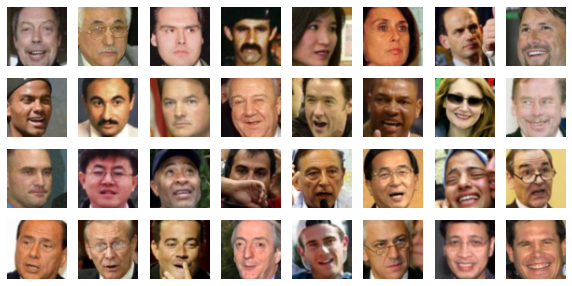

In [9]:
fig = plt.figure(figsize=(10, 5))
for j in range(32):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(0.5*images[j]+0.5)
    ax.axis('off')
plt.show()


### Dataset prefunction 

In [10]:
BATCH_SIZE = 32
EPOCHS = 300
IM_SIZE = (64,64)
SEED_SIZE = 256
IMAGE_CHANNELS = 3 


train_ds = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]
                                        ).batch(BATCH_SIZE,drop_remainder=True)


### Network preparation

In [11]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


trunc = tf.initializers.TruncatedNormal()

In [12]:
def build_generator2(seed_size, chanels):
    

    model = Sequential()

    model.add(Dense(4*4*256, use_bias=False,
                    kernel_initializer= trunc,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Reshape((4,4,256)))

    # 4x4x256 = 4096= 64*64



    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())


    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())


    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())


    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(Conv2D(64,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(Conv2D(chanels,kernel_size=3,padding="same",
                     use_bias=False, kernel_initializer=trunc))
    model.add(Activation("tanh"))
    #64x64x3

    return model




In [13]:

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same",kernel_initializer=trunc))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))



    model.add(Conv2D(32, kernel_size=3, strides=2,padding="same",
                     kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same",
                     kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                     kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same",
                     kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))  
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same",
                     kernel_initializer=trunc))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation=tf.identity))

    return model


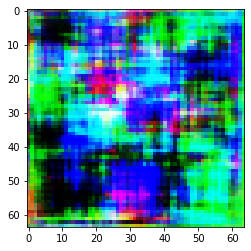

In [14]:
# testing generator

generator = build_generator2(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False).numpy()
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0]);


In [15]:
#testing descriminator

image_shape = (*IM_SIZE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.04048985]], shape=(1, 1), dtype=float32)


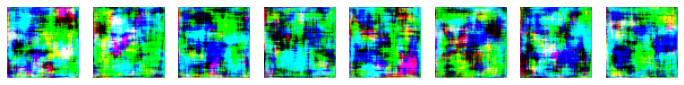

In [16]:
#testing displaying

def display_image(num_rows = 1,num_cols = 8, noise_ = [0]):
    if len(noise_)==1:
        np.random.seed(0)
        noise = np.random.normal(0, 1, (num_rows * num_cols, SEED_SIZE))
    else:
        noise = noise_ 
   
    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    fig = plt.figure(figsize=(num_cols*1.5, num_rows* 1.5))
    
    for i in range(num_rows * num_cols):
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        ax.imshow(generated_images[i])
        ax.axis('off')
    plt.show()


display_image()


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)


### Training model 

In [19]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    

        gradients_of_generator = gen_tape.gradient(gen_loss,
                                        generator.trainable_variables)
    
        gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                        discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                        generator.trainable_variables))
    
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                        discriminator.trainable_variables))
  
    return gen_loss,disc_loss
  

In [20]:

def train(dataset, epochs):
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)


    
    if epochs < 50 or epoch%10 ==0:
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}',
               f'{hms_string(time.time()-epoch_start)}')
        display_image()


  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
  

Epoch 1, gen loss=1.8923124074935913,disc loss=0.9141844511032104 0:01:03.81


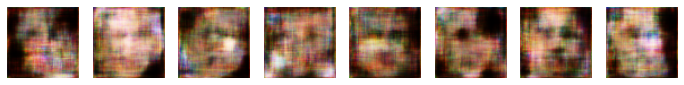

Epoch 11, gen loss=1.1896154880523682,disc loss=1.1303842067718506 0:00:58.29


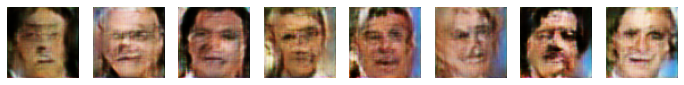

Epoch 21, gen loss=1.0644285678863525,disc loss=1.1989328861236572 0:00:58.38


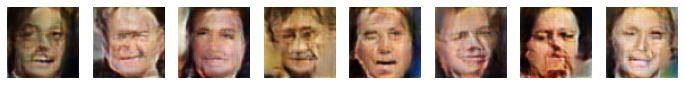

Epoch 31, gen loss=1.0541056394577026,disc loss=1.1929763555526733 0:00:58.34


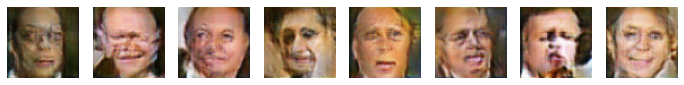

Epoch 41, gen loss=1.094860553741455,disc loss=1.178275227546692 0:00:58.43


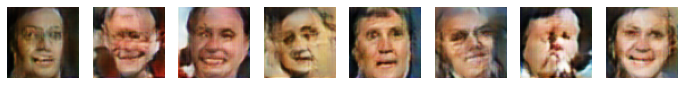

Epoch 51, gen loss=1.1023063659667969,disc loss=1.1676689386367798 0:00:58.36


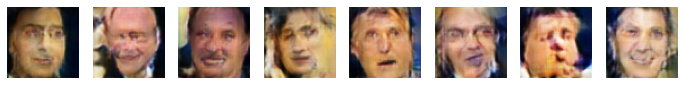

Epoch 61, gen loss=1.1287477016448975,disc loss=1.1518282890319824 0:00:58.45


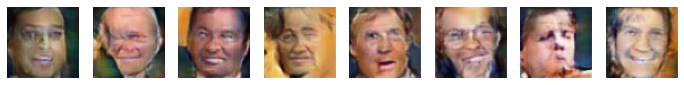

Epoch 71, gen loss=1.1903098821640015,disc loss=1.1205451488494873 0:00:58.48


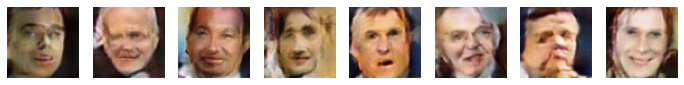

Epoch 81, gen loss=1.232179045677185,disc loss=1.0969316959381104 0:00:58.40


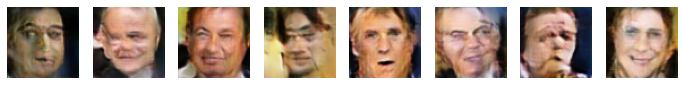

Epoch 91, gen loss=1.2896661758422852,disc loss=1.0766981840133667 0:00:58.54


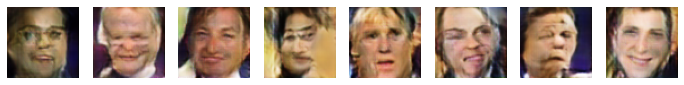

Epoch 101, gen loss=1.3928683996200562,disc loss=1.0145829916000366 0:00:58.53


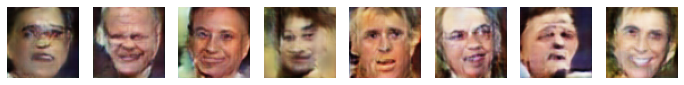

Epoch 111, gen loss=1.4468334913253784,disc loss=1.0046288967132568 0:00:58.55


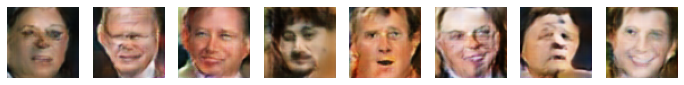

Epoch 121, gen loss=1.5042551755905151,disc loss=1.0033951997756958 0:00:58.60


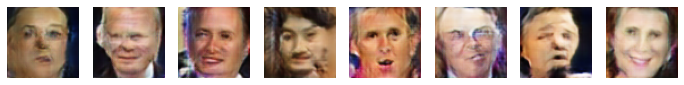

Epoch 131, gen loss=1.5572293996810913,disc loss=0.9677236080169678 0:00:58.48


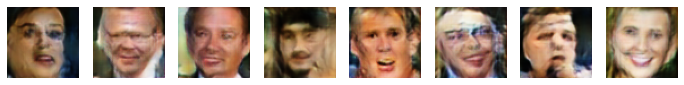

Epoch 141, gen loss=1.6516010761260986,disc loss=0.9299144744873047 0:00:58.46


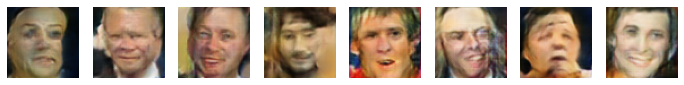

Epoch 151, gen loss=1.684889554977417,disc loss=0.9138956665992737 0:00:58.49


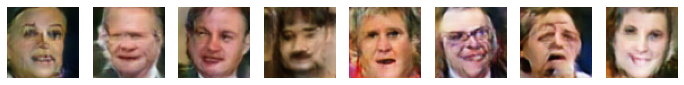

Epoch 161, gen loss=1.754234790802002,disc loss=0.9128842353820801 0:00:58.43


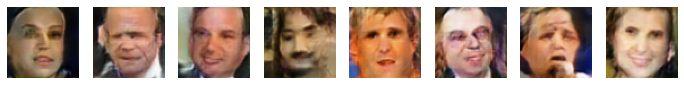

Epoch 171, gen loss=1.860749363899231,disc loss=0.8289040923118591 0:00:58.35


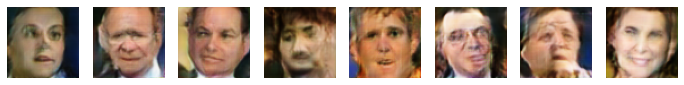

Epoch 181, gen loss=1.8977079391479492,disc loss=0.836713969707489 0:00:58.48


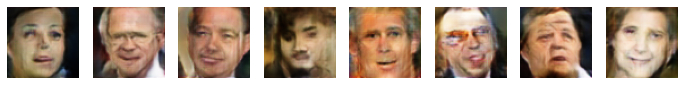

Epoch 191, gen loss=2.011024236679077,disc loss=0.7983622550964355 0:00:58.42


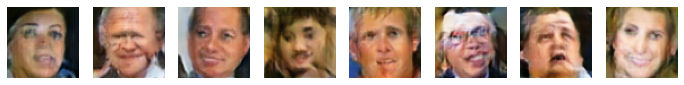

Epoch 201, gen loss=2.0406806468963623,disc loss=0.8007696270942688 0:00:58.53


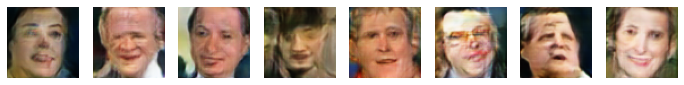

Epoch 211, gen loss=2.0321364402770996,disc loss=0.8083344101905823 0:00:58.53


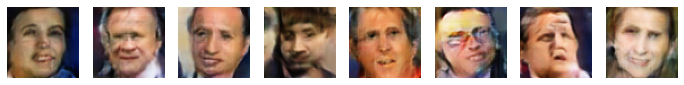

Epoch 221, gen loss=2.118263006210327,disc loss=0.7616616487503052 0:00:58.47


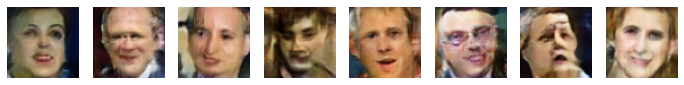

Epoch 231, gen loss=2.233572006225586,disc loss=0.7080160975456238 0:00:58.45


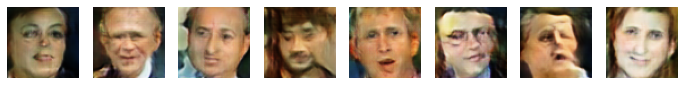

Epoch 241, gen loss=2.200962781906128,disc loss=0.773962676525116 0:00:58.52


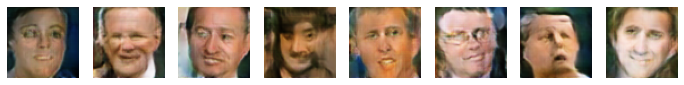

Epoch 251, gen loss=2.3943064212799072,disc loss=0.6850420236587524 0:00:58.50


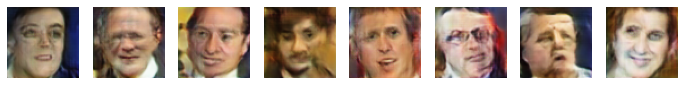

Epoch 261, gen loss=2.420635461807251,disc loss=0.701489269733429 0:00:58.46


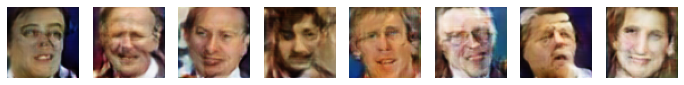

Epoch 271, gen loss=2.458993911743164,disc loss=0.7177894115447998 0:00:58.60


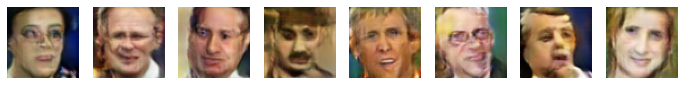

Epoch 281, gen loss=2.4650931358337402,disc loss=0.6926447153091431 0:00:58.55


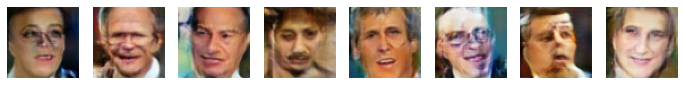

Epoch 291, gen loss=2.417872190475464,disc loss=0.6956058740615845 0:00:58.66


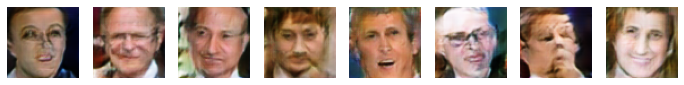

Training time: 4:52:12.08


In [21]:
train(train_ds, EPOCHS)

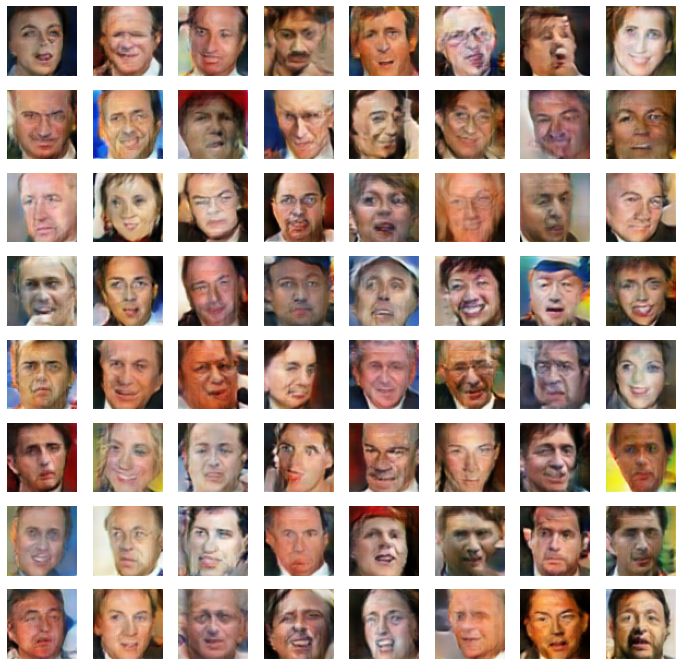

In [22]:
display_image(num_rows = 8,num_cols = 8)

Latent space interpolation

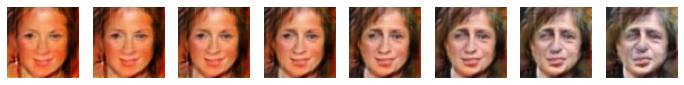

In [25]:
noise_1 = np.random.normal(0, 1, (SEED_SIZE)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (SEED_SIZE)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
display_image(num_rows = 1,num_cols = 8,noise_=noise)